In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import tifffile as tiff
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler

from torchvision import transforms

import torchvision.models as models





**Importing and processing image data**

The dataset is comprised of TIFF files.

The training set is a collection of ".tiff" files
The public test set has some additional ".tiff" files.
The training set includes annotations in both RLE-encoded and unencoded (JSON) forms. The annotations denote segmentations of glomeruli.

File train.csv contains the unique IDs for each image, as well as an RLE-encoded representation of the mask for the objects in the image.

RLE or Run Length Encoding converts a matrix into a vector and returns the position/starting point of the first pixel from where we observe an object (identified by a 1) and gives us a count of how many pixels from that pixel we see the series of 1s. For example coded Mask will look like [1 1 1 0 0 1 1], running RLE would give us 1 3 6 2, which means 3 pixels from the zeroth pixel (inclusive) and 2 pixels from the 5th pixel we see a series of 1s

In [2]:
train_df = pd.read_csv('../input/hubmap-organ-segmentation/train.csv')
train_df.head().T

,0,1,2,3,4
id,10044,10274,10392,10488,10610
organ,prostate,prostate,spleen,lung,spleen
data_source,HPA,HPA,HPA,HPA,HPA
img_height,3000,3000,3000,3000,3000
img_width,3000,3000,3000,3000,3000
pixel_size,0.4,0.4,0.4,0.4,0.4
tissue_thickness,4,4,4,4,4
rle,1459676 77 1462675 82 1465674 87 1468673 92 14...,715707 2 718705 8 721703 11 724701 18 727692 3...,1228631 20 1231629 24 1234624 40 1237623 47 12...,3446519 15 3449517 17 3452514 20 3455510 24 34...,478925 68 481909 87 484893 105 487863 154 4908...
age,37.0,76.0,82.0,78.0,21.0
sex,Male,Male,Male,Male,Female


In [3]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,351.0,16662.914530,9.863946e+03,62.0,8229.0,16609.0,25630.5,32741.0
img_height,351.0,2978.364672,9.096209e+01,2308.0,3000.0,3000.0,3000.0,3070.0
img_width,351.0,2978.364672,9.096209e+01,2308.0,3000.0,3000.0,3000.0,3070.0
pixel_size,351.0,0.400000,1.111808e-16,0.4,0.4,0.4,0.4,0.4
tissue_thickness,351.0,4.000000,0.000000e+00,4.0,4.0,4.0,4.0,4.0
age,351.0,60.364672,1.601333e+01,21.0,55.0,60.0,73.0,84.0


<AxesSubplot:xlabel='organ', ylabel='count'>

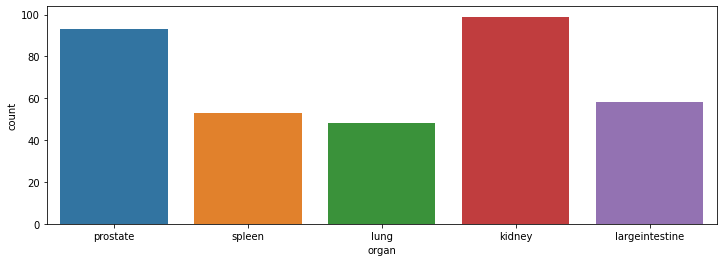

In [4]:
plt.figure(figsize=(12, 4))
sns.countplot(data=train_df, x="organ")

<AxesSubplot:xlabel='age', ylabel='count'>

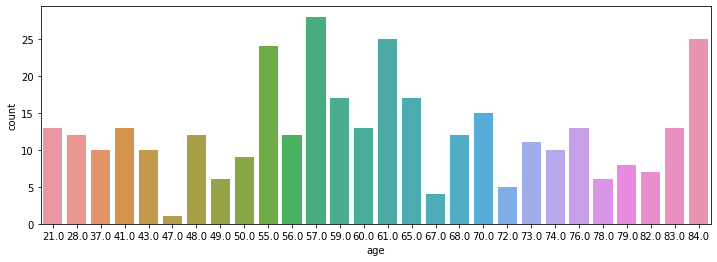

In [5]:
plt.figure(figsize=(12, 4))
sns.countplot(data=train_df, x="age")

<AxesSubplot:xlabel='sex', ylabel='count'>

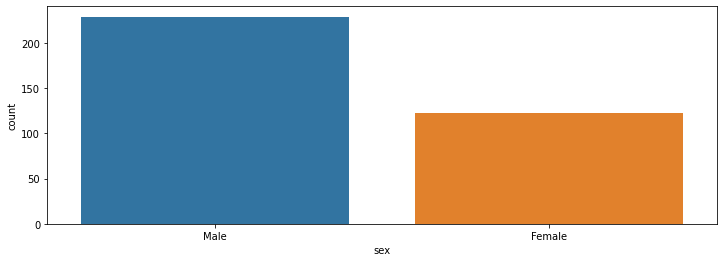

In [6]:
plt.figure(figsize=(12, 4))
sns.countplot(data=train_df, x="sex")

<AxesSubplot:xlabel='organ', ylabel='count'>

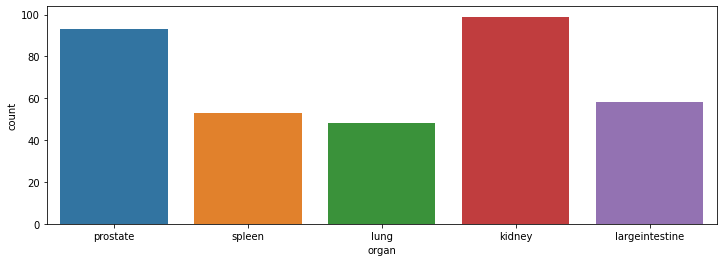

In [7]:
plt.figure(figsize=(12, 4))
sns.countplot(data=train_df, x="organ")

(3000, 3000)


(-0.5, 2999.5, 2999.5, -0.5)

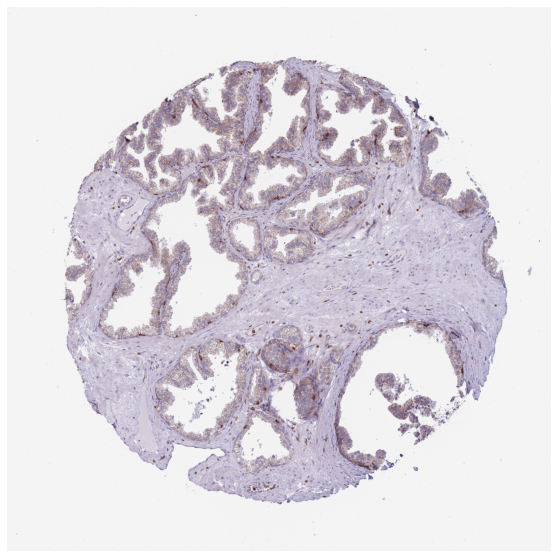

In [8]:
# example

def make_image_path(image_id):
    return "../input/hubmap-organ-segmentation/train_images/{}.tiff".format(image_id)

img_id_1 = train_df.iloc[0,0]
#img_1 = tiff.imread(make_image_path(img_id_1))
img_1 = Image.open(make_image_path(img_id_1))

print(img_1.size)

plt.figure(figsize=(10, 10))
plt.imshow(img_1)
plt.axis("off")

In [9]:
# https://www.kaggle.com/paulorzp/rle-functions-run-length-encode-decode

def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 
def rle2mask(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

(-0.5, 2999.5, 2999.5, -0.5)

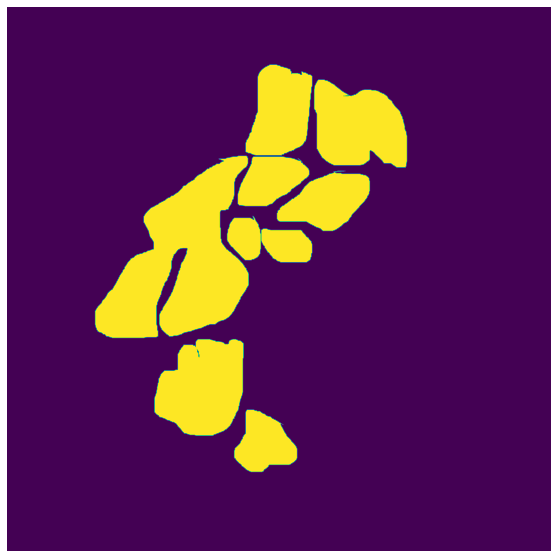

In [10]:
# plot mask
rle = train_df.loc[0,"rle"]
mask_1 = rle2mask(rle, shape=(img_1.size[0], img_1.size[1]))

plt.figure(figsize=(10, 10))
plt.imshow(mask_1)
plt.axis("off")

In [11]:
type(mask_1)

numpy.ndarray

(-0.5, 2999.5, 2999.5, -0.5)

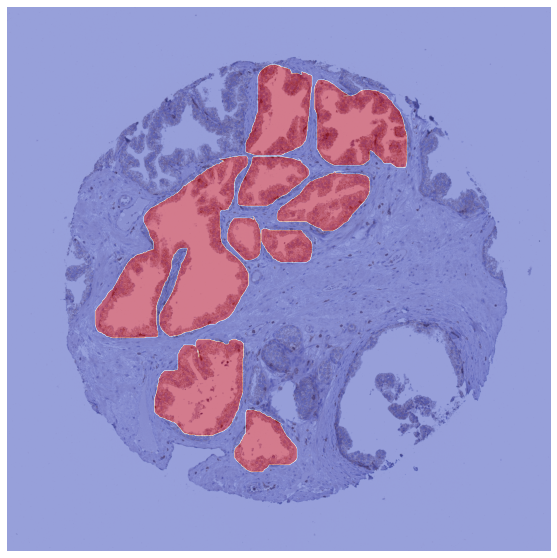

In [12]:
# Combining Image with Mask

plt.figure(figsize=(10,10))
plt.imshow(img_1)
plt.imshow(mask_1, cmap='coolwarm', alpha=0.5)
plt.axis("off")

In [13]:
#! mkdir -p ./train_masks

#from tqdm.auto import tqdm

#for _, row in tqdm(df_train.iterrows(), total=len(df_train)):
#    mask = rle_decode(row['rle'], img_shape=(row["img_height"], row["img_width"]))
#    segm_path = os.path.join("train_masks", f"{row['id']}.png")
#    Image.fromarray(mask.T).save(segm_path)
    # plt.imsave(segm_path, mask.T)

In [14]:
#DataSet

transform_image = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

transform_mask = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        #transforms.ToType(),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])


class HuBMAP_Dataset(Dataset):
    
    def __init__(self, list_idx, list_rle, transform_image=None, transform_mask=None):
        
        super().__init__()
        self.list_idx = list_idx
        self.list_rle = list_rle
        self.transform_image = transform_image
        self.transform_mask = transform_mask
        
        
    def __getitem__(self, index):
    
        
        input_image = Image.open(make_image_path(self.list_idx[index]))
        
        rle = self.list_rle[index]
        input_mask = Image.fromarray(rle2mask(rle, shape=(input_image.size[0], input_image.size[1])))

            
        if self.transform_image:
            image = self.transform_image(input_image)
        
        if self.transform_mask:
            mask = self.transform_mask(input_mask)#.type(torch.int32)
            mask[mask>0] = 1
            #mask = mask.type(torch.int32)
        
        return image, mask
        
        
        
    def __len__(self):
        return len(self.list_idx)

In [15]:
train_dataset = HuBMAP_Dataset(train_df.id, train_df.rle, transform_image, transform_mask )

batch_size = 16

train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    shuffle=True,
)

In [16]:
iter_num = len(train_dataset) // batch_size
print(iter_num)

21


(-0.5, 223.5, 223.5, -0.5)

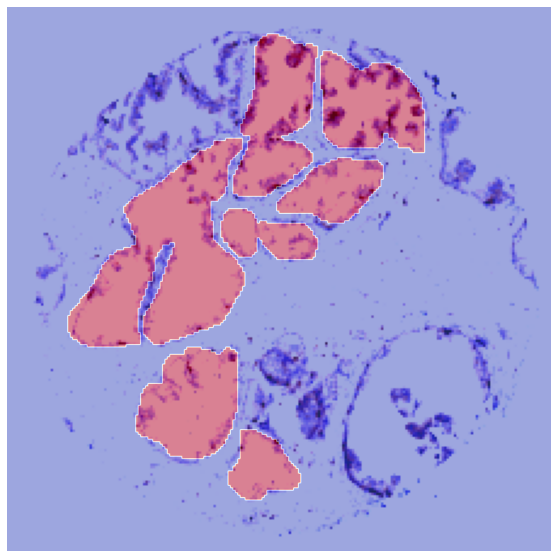

In [17]:
# Check that everything in the right place after transformation

img = train_dataset[0][0].permute(1, 2, 0).numpy()
mask = train_dataset[0][1].permute(1, 2, 0).numpy()

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.imshow(mask, cmap='coolwarm', alpha=0.5)
plt.axis("off")

# Model

In [18]:
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [19]:
model_resnet18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [20]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        #self.base_model = models.resnet18()
        #self.base_model.load_state_dict(torch.load("../input/resnet18/resnet18.pth"))
        self.base_model = model_resnet18
        
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3])
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5])
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        self.activation = nn.Sigmoid()

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

    def predict_proba(self, x):
        return self.activation(self(x))
    
    def predict(self, x, threshold=0.5):
        y_pred = self(x)
        probs = torch.sigmoid(y_pred)
        predicted_vals = probs > threshold
        return predicted_vals

In [21]:
model = UNet(n_class=1).cuda()

In [22]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), weight_decay=1e-4, lr = 0.002, momentum=0.9)

In [23]:
#PyTorch
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

In [24]:

def dice_coeff(pred, target, from_logits=False):
    smooth = 1.
    num = pred.size(0)
    
    #if from_logits: pred = F.sigmoid(pred)
    if from_logits: pred = torch.sigmoid(pred)
        
    m1 = pred.view(num, -1).float()  # Flatten
    m2 = target.view(num, -1).float()  # Flatten
    intersection = (m1 * m2).sum().float()

    return (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)

In [25]:
%%time

for epoch in range(180):      
    model.train()
    epoch_loss = 0
    epoch_dice = 0
    for ii, (data, target) in enumerate(train_loader):                         
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)  
        loss = criterion(output, target)
        
        dice = dice_coeff(output, target, from_logits=True)
        epoch_dice += dice
        
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print('Epoch: {} - Loss: {:.6f} Dice: {:.6f}'.format(epoch + 1, epoch_loss, epoch_dice/iter_num))
    if (epoch_dice/iter_num > 0.9): break

Epoch: 1 - Loss: 13.438446 Dice: 0.209098
Epoch: 2 - Loss: 8.811799 Dice: 0.185686
Epoch: 3 - Loss: 8.235054 Dice: 0.167180
Epoch: 4 - Loss: 8.181134 Dice: 0.180361
Epoch: 5 - Loss: 8.175186 Dice: 0.176165
Epoch: 6 - Loss: 8.163875 Dice: 0.176132
Epoch: 7 - Loss: 8.165126 Dice: 0.174236
Epoch: 8 - Loss: 8.161122 Dice: 0.176928
Epoch: 9 - Loss: 8.146669 Dice: 0.174308
Epoch: 10 - Loss: 8.148841 Dice: 0.173402
Epoch: 11 - Loss: 8.145731 Dice: 0.174953
Epoch: 12 - Loss: 8.130647 Dice: 0.172754
Epoch: 13 - Loss: 8.140746 Dice: 0.170076
Epoch: 14 - Loss: 8.135158 Dice: 0.176162
Epoch: 15 - Loss: 8.119278 Dice: 0.173432
Epoch: 16 - Loss: 8.125616 Dice: 0.169722
Epoch: 17 - Loss: 8.116659 Dice: 0.173031
Epoch: 18 - Loss: 8.109706 Dice: 0.170790
Epoch: 19 - Loss: 8.109305 Dice: 0.173080
Epoch: 20 - Loss: 8.114949 Dice: 0.168964
Epoch: 21 - Loss: 8.097765 Dice: 0.173941
Epoch: 22 - Loss: 8.096459 Dice: 0.172416
Epoch: 23 - Loss: 8.093630 Dice: 0.169743
Epoch: 24 - Loss: 8.084967 Dice: 0.170058


In [26]:
torch.save(model, 'model.pth')

In [27]:
# model2 = torch.load('model.pth')
# model2

In [28]:
model.eval()
for data, mask in train_loader:                         
    data = data.cuda()
    output = model.predict_proba(data)
    break

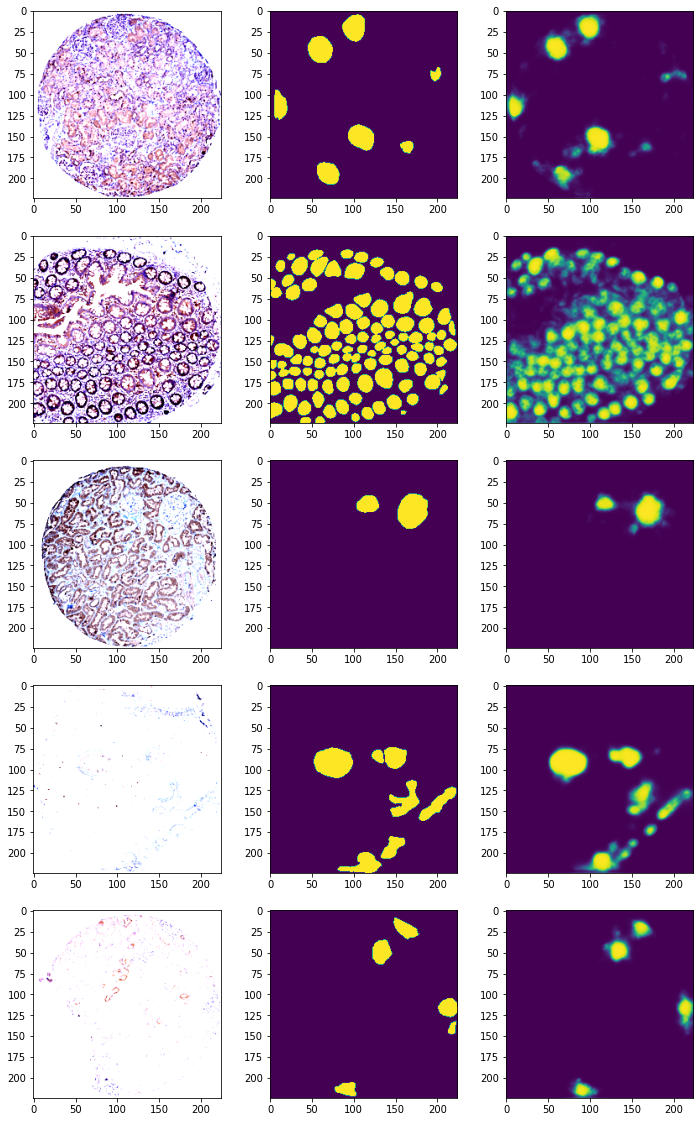

In [29]:

fig, ax = plt.subplots(ncols=3, nrows=5, figsize=(12, 4*5))
for i in range(5):
    img = data[i].permute(1, 2, 0).cpu().numpy() 
    targ = mask[i].permute(1, 2, 0).cpu().numpy() 
    test_mask = output[i].permute(1, 2, 0).cpu().detach().numpy()


    ax[i][0].imshow(img)
    ax[i][1].imshow(targ)#, cmap='coolwarm', alpha=0.5)
    ax[i][2].imshow(test_mask)
    
    #plt.colorbar(test_mask, ax=ax[i][2])
#plt.axis("off")

# Test image

In [30]:
test_df = pd.read_csv('../input/hubmap-organ-segmentation/test.csv')
test_df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness
0,10078,spleen,Hubmap,2023,2023,0.4945,4


In [31]:
test_image_path_list = ["../input/hubmap-organ-segmentation/test_images/{}.tiff".format(image_id) for image_id in test_df.id.values]
test_image_path_list

['../input/hubmap-organ-segmentation/test_images/10078.tiff']

In [32]:
#fig, ax = plt.subplots(ncols=max(2,len(test_image_path_list)), nrows=1, figsize=(16, 4))
#or i in range(len(test_image_path_list)):
#    image = Image.open(test_image_path_list[i])
#    ax[i].imshow(image)

(-0.5, 2022.5, 2022.5, -0.5)

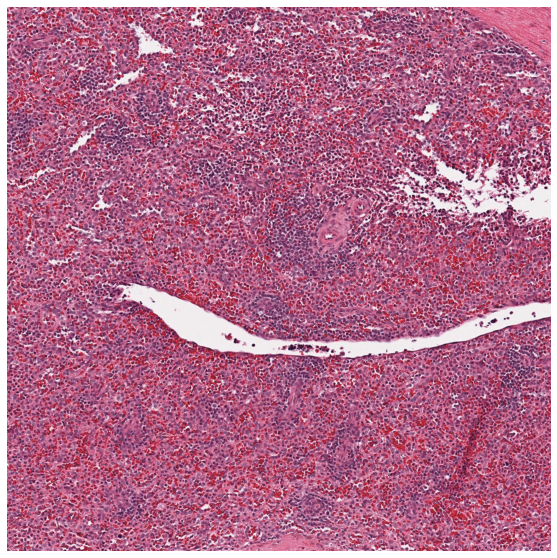

In [33]:
test_image_path = test_image_path_list[0]
test_image = Image.open(test_image_path)

plt.figure(figsize=(10, 10))
plt.imshow(test_image)
plt.axis("off")

In [34]:
class HuBMAP_Dataset_test(Dataset):
    
    def __init__(self, list_path, transform_image=None):
        super().__init__()
        self.list_path = list_path
        self.transform_image = transform_image
        
    def __getitem__(self, index):
        input_image = Image.open(self.list_path[index])

        if self.transform_image:
            image = self.transform_image(input_image)
               
        return image

    def __len__(self):
        return len(self.list_path)

    
    
test_dataset = HuBMAP_Dataset_test(test_image_path_list, transform_image)

test_loader = DataLoader(
    dataset = test_dataset,
    batch_size = 1,
    shuffle=True,
)

#next(iter(train_loader))

In [35]:
print(next(iter(test_loader))[0].shape)

torch.Size([3, 224, 224])


(-0.5, 223.5, 223.5, -0.5)

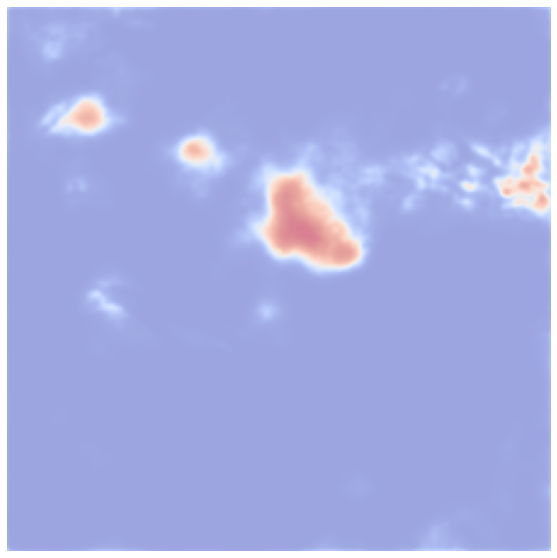

In [36]:
model.eval()
for data in test_loader:                         
    data = data.cuda()
    output = model.predict_proba(data)

    
img = data[0].permute(1, 2, 0).cpu().numpy() 
#output[output>0] = 1
#output[output<0] = 0
test_mask = output[0].permute(1, 2, 0).cpu().detach().numpy()

plt.figure(figsize=(10,10))
#plt.imshow(img)
plt.imshow(test_mask, cmap='coolwarm', alpha=0.5)
plt.axis("off")

In [37]:
print(test_mask.max(), test_mask.mean(), test_mask.min())
m = test_mask.mean()

0.95095944 0.039705656 7.765293e-06


(-0.5, 223.5, 223.5, -0.5)

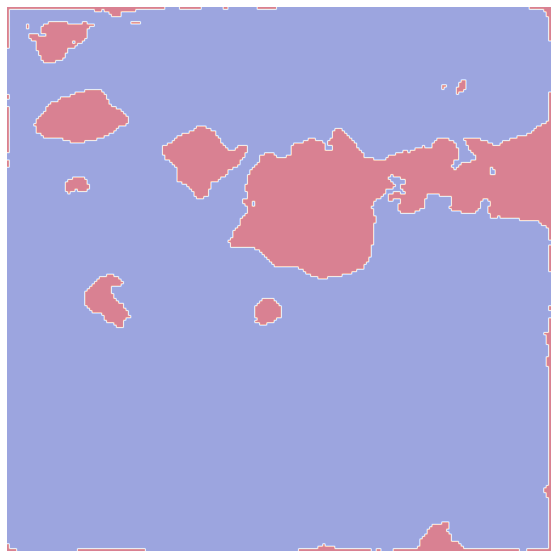

In [38]:
test_mask[test_mask>m]=1
test_mask[test_mask<m]=0
plt.figure(figsize=(10,10))
#plt.imshow(img)
plt.imshow(test_mask, cmap='coolwarm', alpha=0.5)
plt.axis("off")

(-0.5, 223.5, 223.5, -0.5)

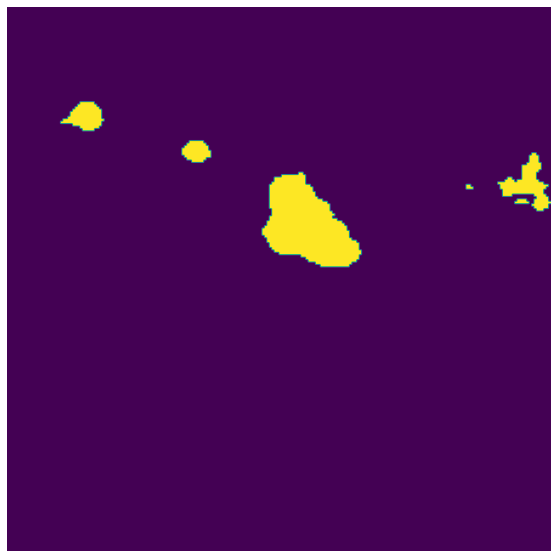

In [39]:
model.eval()

test_mask_list = []
for data in test_loader:                         
    data = data.cuda()
    output = model.predict(data)
    test_mask_list.append(Image.fromarray(np.uint8(output[0].squeeze().cpu().detach().numpy())))
    
img = data[0].permute(1, 2, 0).cpu().numpy() 
test_mask = output[0].permute(1, 2, 0).cpu().detach().numpy()
plt.figure(figsize=(10,10))
#plt.imshow(img)
plt.imshow(test_mask)
plt.axis("off")

In [40]:
output[0].permute(1, 2, 0).cpu().detach().numpy().shape

(224, 224, 1)

In [41]:
im = Image.fromarray(np.uint8(output[0].squeeze().cpu().detach().numpy()))
im_scaled = im.resize(test_image.size)
im_scaled.size

(2023, 2023)

In [42]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    #print(pixels.shape)   
    #print(pixels)   
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

0 (2023, 2023)
(2023, 2023)


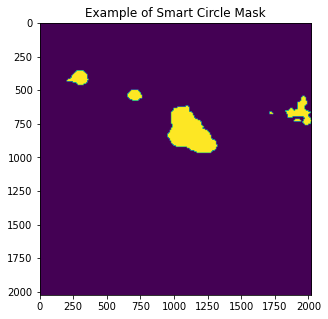

,id,rle
0,10078,403002 10 405025 10 407048 10 409071 10 411094...


In [43]:
rles = []
SMART_CIRCLE_FRAC = 0.85


for i, (img_w, img_h) in enumerate(zip(test_df["img_width"], test_df["img_height"])):
    
    #tmp_img = np.zeros((img_w, img_h))
    #tmp_img = cv2.circle(tmp_img, (int(np.round(img_w/2)), int(np.round(img_h/2))), int(np.round((img_w/2)*SMART_CIRCLE_FRAC)), 1, -1)
    print(i, (img_w, img_h))
    tmp_img = np.array(test_mask_list[i].resize((img_w, img_h)))
    print(tmp_img.shape)
    rle = mask2rle(tmp_img)
    rles.append(rle)
    
    #if i==0:
plt.figure(figsize=(5,5))
plt.imshow(rle2mask(rles[-1], (img_w, img_h)))
plt.title("Example of Smart Circle Mask")
plt.show()

test_df["rle"] = rles
submission_df = test_df[["id", "rle"]]
submission_df.to_csv("submission.csv", index=False)
display(submission_df)

In [44]:
rles

['403002 10 405025 10 407048 10 409071 10 411094 10 413117 10 415140 10 417163 10 419186 10 421200 19 423223 19 425246 19 427269 19 429292 19 431315 19 433338 19 435361 19 437384 19 439407 19 441430 19 443453 19 445476 19 447499 19 449522 19 451545 19 453568 19 455591 19 457605 28 459628 28 461651 28 463674 28 465697 28 467720 28 469743 28 471766 28 473789 28 475794 46 477817 46 479840 46 481863 46 483886 46 485909 46 487932 46 489955 46 491978 46 493992 64 496015 64 498038 64 500061 64 502084 64 504107 64 506130 64 508153 64 510176 64 512190 73 514213 73 516236 73 518259 73 520282 73 522305 73 524328 73 526351 73 528374 73 530388 82 532411 82 534434 82 536457 82 538480 82 540503 82 542526 82 544549 82 546572 82 548586 100 550609 100 552632 100 554655 100 556678 100 558701 100 560724 100 562747 100 564770 100 566793 109 568816 109 570839 109 572862 109 574885 109 576908 109 578931 109 580954 109 582977 109 585000 109 587023 109 589046 109 591069 109 593092 109 595115 109 597138 109 599